In [1]:
import sys
sys.path.append("src")  # 确保 src 目录在 Python 路径中
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gnns.classifier
import gnns.data
import gnns.metrics
import gnns.selecter
import networkx as nx

# 添加中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

file_path = "data"  # dataset_path

In [ ]:
# 阈值 vs 非零边数（稀疏度）折线图
X, y, gene_names, sample_ids = gnns.data.load_data(file_path,method='lxs',read=False,use_deg=True)
adjacency, X, y = gnns.data.get_graph_data(X,y,corr_method='pearson')
def plot_threshold_vs_edges(X, method='pearson', thresholds=np.linspace(0, 1, 50)):
    edge_counts = []

    for t in thresholds:
        adj, _, _ = gnns.data.get_graph_data(X, y=None, corr_method=method, threshold=t)
        # 除去对角线，仅统计上三角非零元素个数（无向图）
        num_edges = np.count_nonzero(np.triu(adj, k=1))
        edge_counts.append(num_edges)

    plt.plot(thresholds, edge_counts, marker='o')
    plt.xlabel("Threshold")
    plt.ylabel("Number of Edges (non-zero)")
    plt.title(f"Threshold vs Edge Count ({method})")
    plt.grid(True)
    plt.show()
plot_threshold_vs_edges(X)

In [ ]:
# 自动选择阈值、构建邻接矩阵并评估图稀疏性
def evaluate_thresholds(corr_matrix, thresholds=[0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9]):
    num_nodes = corr_matrix.shape[0]
    results = []

    plt.figure(figsize=(6,4))
    plt.hist(corr_matrix.flatten(), bins=100)
    plt.title("Correlation Matrix Distribution")
    plt.xlabel("Pearson r")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    for threshold in thresholds:
        adj = (corr_matrix > threshold).astype(int)
        np.fill_diagonal(adj, 0)  # remove self-loops
        num_edges = np.sum(adj) // 2
        edge_density = num_edges / (num_nodes * (num_nodes - 1) / 2)

        # 使用 NetworkX 分析
        G = nx.from_numpy_array(adj)
        degrees = dict(G.degree())
        isolated_nodes = [n for n, d in degrees.items() if d == 0]
        avg_degree = np.mean(list(degrees.values()))
        num_components = nx.number_connected_components(G)

        results.append({
            'threshold': threshold,
            'num_edges': num_edges,
            'edge_density': edge_density,
            'avg_degree': avg_degree,
            'num_isolated': len(isolated_nodes),
            'num_components': num_components
        })

    # 打印表格
    print(f"{'Threshold':<10} {'Edges':<10} {'Density':<10} {'Avg Degree':<12} {'Isolated':<10} {'Components':<10}")
    for r in results:
        print(f"{r['threshold']:<10.2f} {r['num_edges']:<10} {r['edge_density']:<10.4f} {r['avg_degree']:<12.2f} {r['num_isolated']:<10} {r['num_components']:<10}")
    
    # 可视化指标趋势
    thresholds = [r['threshold'] for r in results]
    densities = [r['edge_density'] for r in results]
    avg_degrees = [r['avg_degree'] for r in results]
    isolated = [r['num_isolated'] for r in results]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(thresholds, densities, marker='o')
    plt.title("Edge Density vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Edge Density")

    plt.subplot(1, 3, 2)
    plt.plot(thresholds, avg_degrees, marker='o', color='green')
    plt.title("Average Degree vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Avg Degree")

    plt.subplot(1, 3, 3)
    plt.plot(thresholds, isolated, marker='o', color='red')
    plt.title("Isolated Nodes vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Isolated Nodes")

    plt.tight_layout()
    plt.show()

    return results

X, y, gene_names, sample_ids = gnns.data.load_data(file_path,method='lxs',read=False,use_deg=True)
corr_matrix, X, y = gnns.data.get_graph_data(X,y,corr_method='pearson',threshold=0)
results = evaluate_thresholds(corr_matrix)
print("Min:", np.min(corr_matrix))
print("Max:", np.max(corr_matrix))
print("Mean:", np.mean(corr_matrix))



In [ ]:
# 用于判断select_data_variance的阈值。
X, y, gene_names, sample_ids = gnns.data.load_data('data')
df_var = gnns.metrics.check_gene_variances(X, gene_names)

# 查看前5个方差最大的基因：
print(df_var.head(5))
# 查看前5个方差最小的基因：
print(df_var.tail(5))

# 输出统计描述
print(df_var['Variance'].describe())

# 创建画布
plt.figure(figsize=(10, 2.5), dpi=150)

# 画箱线图
sns.boxplot(
    x=df_var['Variance'],
    color="#99c2a2",  # 温和绿
    linewidth=1.2,
    fliersize=3  # 离群点大小
)

# 坐标细致一点，设置刻度间距
min_val = df_var['Variance'].min()
max_val = df_var['Variance'].max()
step = (max_val - min_val) / 10  # 分成10段

plt.xticks(np.round(np.arange(min_val, max_val + step, step), 3))  # 保留三位小数
plt.xlabel('Variance', fontsize=10)
plt.title('Boxplot of Gene Variances', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# 用于判断select_data_variance的阈值。
X, y, gene_ids, sample_ids = gnns.data.load_data('data')
X = np.log1p(X)
df_var = gnns.metrics.check_gene_variances(X, gene_ids)

# 查看前5个方差最大的基因：
print(df_var.head(5))

# 查看前5个方差最小的基因：
print(df_var.tail(5))

# 输出统计描述
print(df_var['Variance'].describe())

# 可以画一个直方图(log10)，看看方差整体分布
log_vars = np.log10(df_var['Variance'] + 1e-6)  # 避免 log(0)
plt.hist(log_vars, bins=100)
plt.title("Log-scaled Distribution of Gene Variances")
plt.xlabel("log10(Variance)")
plt.ylabel("Gene Count")
plt.show()

In [ ]:
# 可视化方差选出的基因相关热图
X, y, gene_names, sample_ids = gnns.data.load_data(file_path,method='variance')
# 计算相关系数矩阵
correlation_matrix = np.corrcoef(X.T)

# 对相关性矩阵进行排序
# 计算每个基因与其他基因的平均相关性
mean_corr = np.mean(np.abs(correlation_matrix), axis=1)
# 获取排序后的索引
sorted_idx = np.argsort(mean_corr)[::-1]
# 重新排列相关性矩阵
sorted_correlation_matrix = correlation_matrix[sorted_idx][:, sorted_idx]

# 创建热图
plt.figure(figsize=(12, 10))
sns.heatmap(sorted_correlation_matrix, 
            xticklabels=False,
            yticklabels=False,
            cmap='coolwarm',
            center=0,
            annot=False)

plt.title('Sorted Gene Correlation Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
# 阈值 vs 非零边数（稀疏度）折线图 样本为节点
# 加载数据
X, y, gene_names, sample_ids = gnns.data.load_data(file_path,method='variance')

# 获取基因表达矩阵和标签，样本作为节点
# 此时，X应该是样本数 × 基因数的矩阵
def plot_threshold_vs_edges_samples(X, method='pearson', thresholds=np.linspace(0, 1, 50)):
    edge_counts = []

    # 转置X，变成每一行代表一个样本，每一列代表一个基因
    X_samples = X.T  # 样本之间的相关性矩阵

    for t in thresholds:
        # 计算样本之间的相关性矩阵
        adj, _, _ = gnns.data.get_graph_data(X_samples, y=None, corr_method=method, threshold=t)
        
        # 除去对角线，仅统计上三角非零元素个数（无向图）
        num_edges = np.count_nonzero(np.triu(adj, k=1))
        edge_counts.append(num_edges)

    # 绘制阈值 vs 非零边数的折线图
    plt.plot(thresholds, edge_counts, marker='o')
    plt.xlabel("Threshold")
    plt.ylabel("Number of Edges (non-zero)")
    plt.title(f"Threshold vs Edge Count (Sample Nodes, {method})")
    plt.grid(True)
    plt.show()

# 调用函数
plot_threshold_vs_edges_samples(X)


data\deg_genes_fc0.27_p0.05.txt


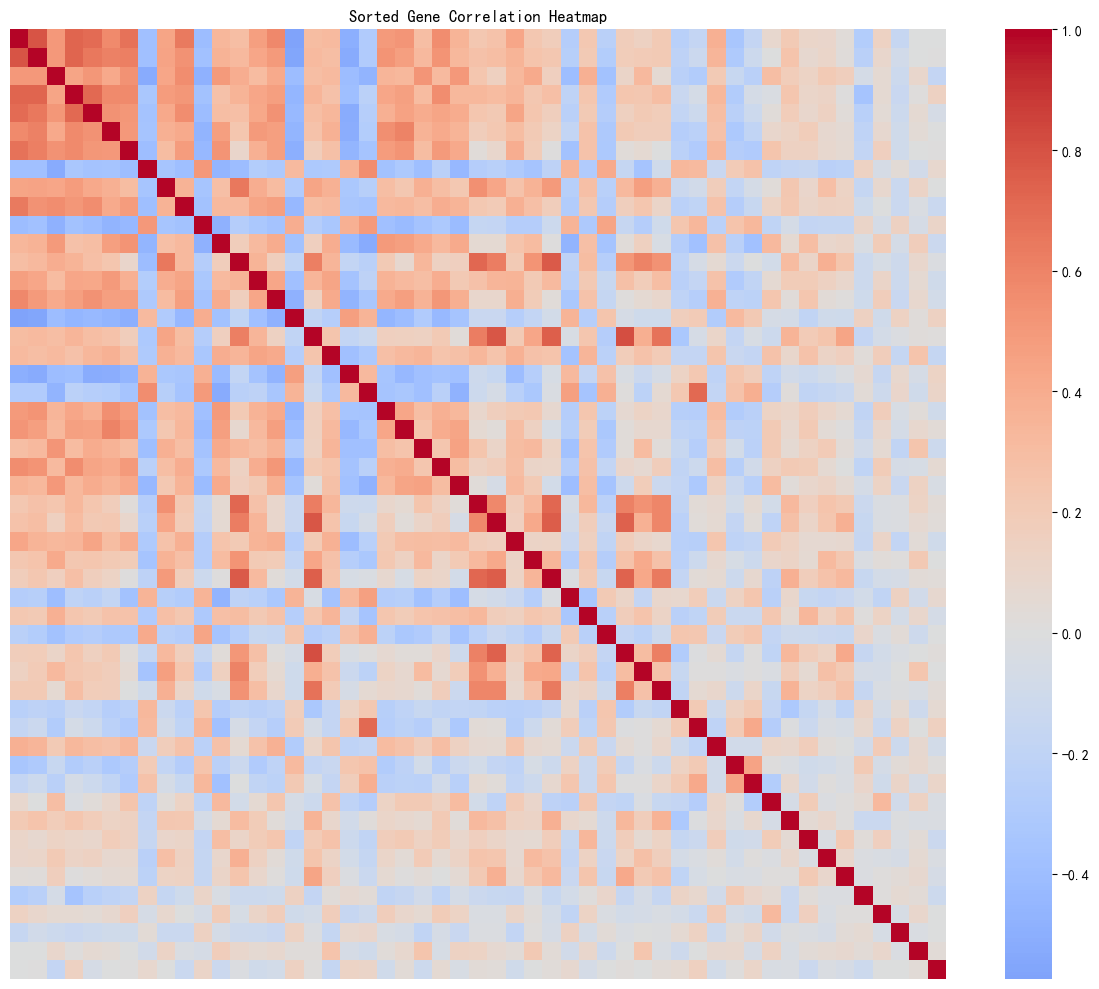

In [2]:
# 可视化lxs方法选出的基因相关热图
X, y, gene_names, sample_ids = gnns.data.load_data(file_path,method='lxs')
# 计算相关系数矩阵
correlation_matrix = np.corrcoef(X.T)

# 对相关性矩阵进行排序
# 计算每个基因与其他基因的平均相关性
mean_corr = np.mean(np.abs(correlation_matrix), axis=1)
# 获取排序后的索引
sorted_idx = np.argsort(mean_corr)[::-1]
# 重新排列相关性矩阵
sorted_correlation_matrix = correlation_matrix[sorted_idx][:, sorted_idx]

# 创建热图
plt.figure(figsize=(12, 10))
sns.heatmap(sorted_correlation_matrix, 
            xticklabels=False,
            yticklabels=False,
            cmap='coolwarm',
            center=0,
            annot=False)

plt.title('Sorted Gene Correlation Heatmap')
plt.tight_layout()
plt.show()

# 如果想要保存图片
# plt.savefig('gene_correlation_heatmap.png', dpi=300, bbox_inches='tight')

In [ ]:
# 可视化lxs方法不同参数筛选出的基因数量
X, y, gene_names, sample_ids = gnns.data.load_data(file_path,method='lxs',read=False,use_deg=False)
# 设置参数范围
low_expr_cutoffs = np.linspace(1.0, 3.0, 30)   
sample_percents = np.linspace(0.1, 1.0, 10 )    
var_cutoff = 1  # 固定变异度阈值

# 保存结果的矩阵，用于存储每个参数组合下筛选后的基因数量
results = np.zeros((len(sample_percents), len(low_expr_cutoffs)))

# 遍历不同参数组合
for i, sp in enumerate(sample_percents):
    for j, lec in enumerate(low_expr_cutoffs):
        _, _, filtered_gene_names, _ = gnns.selecter.lxs(
            X, y, gene_names, sample_ids,
            low_expr_cutoff=lec,
            sample_percent=sp,
            var_cutoff=var_cutoff,
            use_deg=False
        )
        results[i, j] = len(filtered_gene_names)
        print(f"low_expr_cutoff: {lec:.2f}, sample_percent: {sp:.2f}, final gene count: {results[i, j]}")

# 绘制热图展示不同参数下的最终基因数量
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(results, aspect='auto', origin='lower',
                extent=[low_expr_cutoffs[0], low_expr_cutoffs[-1],
                        sample_percents[0], sample_percents[-1]])
ax.set_xlabel("Low Expression Cutoff")
ax.set_ylabel("Sample Percent")
ax.set_title("Final Gene Count after Filtering")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Number of Genes")
plt.show()

In [ ]:
# 可视化作用log + 1 前后的数据分布情况
X, y, gene_names, sample_ids = gnns.data.load_data(file_path,read=False,use_deg=False)

# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 创建原始数据的副本
X_original = X.copy()

# 应用log+1变换
X_log = np.log1p(X_original)  # log(1+x)

# 可视化变换前后的分布
plt.figure(figsize=(15, 10))

# 1. 原始数据的频数分布直方图
plt.subplot(2, 2, 1)
plt.hist(X_original.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('原始数据的频数分布')
plt.xlabel('值')
plt.ylabel('频数')
plt.grid(True, linestyle='--', alpha=0.7)

# 2. log变换后数据的频数分布直方图
plt.subplot(2, 2, 2)
plt.hist(X_log.flatten(), bins=50, alpha=0.7, color='green')
plt.title('log(1+x)变换后的频数分布')
plt.xlabel('log(1+x)值')
plt.ylabel('频数')
plt.grid(True, linestyle='--', alpha=0.7)

# 3. 原始数据的密度分布图
plt.subplot(2, 2, 3)
sns.kdeplot(X_original.flatten(), fill=True, color='blue', alpha=0.5)
plt.title('原始数据的密度分布')
plt.xlabel('值')
plt.ylabel('密度')
plt.grid(True, linestyle='--', alpha=0.7)

# 4. log变换后数据的密度分布图
plt.subplot(2, 2, 4)
sns.kdeplot(X_log.flatten(), fill=True, color='green', alpha=0.5)
plt.title('log(1+x)变换后的密度分布')
plt.xlabel('log(1+x)值')
plt.ylabel('密度')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 计算频数分布的统计信息
def calculate_frequency_stats(data):
    # 将数据分成10个等宽的区间
    hist, bin_edges = np.histogram(data.flatten(), bins=10)
    total = np.sum(hist)
    
    # 计算每个区间的频率百分比
    percentages = (hist / total) * 100
    
    # 返回区间边界和对应的频率百分比
    return bin_edges, percentages

# 计算原始数据和log变换后数据的频数分布
original_bins, original_percentages = calculate_frequency_stats(X_original)
log_bins, log_percentages = calculate_frequency_stats(X_log)

# 打印频数分布信息
print("原始数据频数分布:")
for i in range(len(original_percentages)):
    print(f"区间 [{original_bins[i]:.2f}, {original_bins[i+1]:.2f}]: {original_percentages[i]:.2f}%")

print("\nlog(1+x)变换后频数分布:")
for i in range(len(log_percentages)):
    print(f"区间 [{log_bins[i]:.2f}, {log_bins[i+1]:.2f}]: {log_percentages[i]:.2f}%")
# 可视化变换前后的分布
plt.figure(figsize=(15, 10))

# 1. 原始数据的频数分布直方图 - 使用对数刻度以便更好地观察
plt.subplot(2, 2, 1)
plt.hist(X_original.flatten(), bins=100, alpha=0.7, color='blue')
plt.title('原始数据的频数分布')
plt.xlabel('值')
plt.ylabel('频数')
plt.yscale('log')  # 使用对数刻度以便观察小频数值
plt.grid(True, linestyle='--', alpha=0.7)

# 2. log变换后数据的频数分布直方图
plt.subplot(2, 2, 2)
plt.hist(X_log.flatten(), bins=100, alpha=0.7, color='green')
plt.title('log(1+x)变换后的频数分布')
plt.xlabel('log(1+x)值')
plt.ylabel('频数')
plt.grid(True, linestyle='--', alpha=0.7)

# 3. 原始数据的密度分布图 - 限制x轴范围以便更好地观察
plt.subplot(2, 2, 3)
# 计算95%的数据范围，避免极端值影响可视化
q_low, q_high = np.percentile(X_original.flatten(), [1, 99])
sns.kdeplot(X_original.flatten(), fill=True, color='blue', alpha=0.5)
plt.xlim(q_low, q_high)  # 限制x轴范围
plt.title('原始数据的密度分布 (1%-99%范围)')
plt.xlabel('值')
plt.ylabel('密度')
plt.grid(True, linestyle='--', alpha=0.7)

# 4. log变换后数据的密度分布图
plt.subplot(2, 2, 4)
q_low_log, q_high_log = np.percentile(X_log.flatten(), [1, 99])
sns.kdeplot(X_log.flatten(), fill=True, color='green', alpha=0.5)
plt.xlim(q_low_log, q_high_log)  # 限制x轴范围
plt.title('log(1+x)变换后的密度分布 (1%-99%范围)')
plt.xlabel('log(1+x)值')
plt.ylabel('密度')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 添加一个直接对比图，展示变换前后的分布差异
plt.figure(figsize=(12, 6))

# 对比原始数据和log变换后数据的分布
plt.subplot(1, 2, 1)
# 使用更多的bins以捕捉分布细节
counts_orig, bins_orig, _ = plt.hist(X_original.flatten(), bins=100, alpha=0.5, color='blue', label='原始数据')
plt.title('原始数据分布')
plt.xlabel('值')
plt.ylabel('频数')
plt.yscale('log')  # 使用对数刻度
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
counts_log, bins_log, _ = plt.hist(X_log.flatten(), bins=100, alpha=0.5, color='green', label='log(1+x)变换后')
plt.title('log(1+x)变换后分布')
plt.xlabel('log(1+x)值')
plt.ylabel('频数')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# 做完log+1以后的方差分布图
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gnns.data

# 加载数据
X, y, gene_names, sample_ids = gnns.data.load_data(file_path, read=False, use_deg=False)

# 应用log+1变换
X_log = np.log1p(X)  # log(1+x)

# 计算每个基因(特征)的方差
gene_variances = np.var(X_log, axis=0)  # axis=0表示沿样本方向计算每个基因的方差

# 绘制方差分布图
plt.figure(figsize=(12, 8))

# 1. 方差的直方图
plt.subplot(2, 2, 1)
plt.hist(gene_variances, bins=50, alpha=0.7, color='purple')
plt.title('log(1+x)变换后基因表达量的方差分布')
plt.xlabel('方差')
plt.ylabel('频数')
plt.grid(True, linestyle='--', alpha=0.7)

# 2. 方差的密度图
plt.subplot(2, 2, 2)
sns.kdeplot(gene_variances, fill=True, color='purple', alpha=0.5)
plt.title('log(1+x)变换后基因表达量的方差密度分布')
plt.xlabel('方差')
plt.ylabel('密度')
plt.grid(True, linestyle='--', alpha=0.7)

# 3. 方差的箱线图
plt.subplot(2, 2, 3)
plt.boxplot(gene_variances, vert=False)
plt.title('log(1+x)变换后基因表达量的方差箱线图')
plt.xlabel('方差')
plt.grid(True, linestyle='--', alpha=0.7)

# 4. 方差排序后的曲线图
plt.subplot(2, 2, 4)
sorted_variances = np.sort(gene_variances)[::-1]  # 降序排列
plt.plot(range(len(sorted_variances)), sorted_variances, 'o-', markersize=2, alpha=0.7, color='purple')
plt.title('log(1+x)变换后基因表达量的方差排序图')
plt.xlabel('基因排序索引')
plt.ylabel('方差')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 打印方差的基本统计信息
print("log(1+x)变换后基因表达量方差的统计信息:")
print(f"最小方差: {np.min(gene_variances):.6f}")
print(f"最大方差: {np.max(gene_variances):.6f}")
print(f"平均方差: {np.mean(gene_variances):.6f}")
print(f"中位数方差: {np.median(gene_variances):.6f}")
print(f"方差的标准差: {np.std(gene_variances):.6f}")

# 找出方差最大和最小的几个基因
if gene_names is not None:
    top_n = 10  # 显示前10个方差最大的基因
    top_var_indices = np.argsort(gene_variances)[::-1][:top_n]
    
    print(f"\n方差最大的{top_n}个基因:")
    for i, idx in enumerate(top_var_indices):
        print(f"{i+1}. {gene_names[idx]}: {gene_variances[idx]:.6f}")
    
    bottom_n = 10  # 显示前10个方差最小的基因
    bottom_var_indices = np.argsort(gene_variances)[:bottom_n]
    
    print(f"\n方差最小的{bottom_n}个基因:")
    for i, idx in enumerate(bottom_var_indices):
        print(f"{i+1}. {gene_names[idx]}: {gene_variances[idx]:.6f}")

In [ ]:
# 消融实验
import matplotlib.pyplot as plt

# 数据准备
labels = ['无残差连接', '有残差连接', 'ReLU激活', 'Swish激活']
accuracies = [0.7531, 0.7685, 0.6891, 0.7685]

# 设置颜色
colors = ['#f7a072', '#72bcd4', '#f4d35e', '#90be6d']

# 画图
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=colors)

# 添加数值标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0.65, 0.78)
plt.ylabel('分类准确率', fontsize=12)
plt.title('残差连接与激活函数对模型性能的影响', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=15)
plt.show()
